# Preliminaries

The Visual Coding Neuropixels dataset contains information about (i) extracellular spike recordings (ii) local field potentials and (iii) motor responses. We will focus only on the first one, as the LFP data and motor responses is memory-demanding.

**Warning! the entire dataset is almost 1TB. Each individual session, including only spike data, is around 1-3GB. Do not try to download multiple sessions without checking available space in your computer**. The entire spike dataset is about 120GB and LFP weights on the order of 700GB. For the projects, a single session of spike data (or a very reduced number of them) is more than enough. LFP will not be used.

**Reminder: activate the `envallen` environment to work with this file**

## Useful links 

- [In the main page of the neuropixels data](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) you can find more tutorials. In fact, this notebook was made using the [Data Access](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_data_access.html), the [Quickstart](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quickstart.html) and part of the [Full guide](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html) tutorials together, but more information and examples can be found there.

- Information about the [natural scenes](https://observatory.brain-map.org/visualcoding/stimulus/natural_scenes) and the [natural movies](https://observatory.brain-map.org/visualcoding/stimulus/natural_movies).

- [A cheatsheet](https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/0f/5d/0f5d22c9-f8f6-428c-9f7a-2983631e72b4/neuropixels_cheat_sheet_nov_2019.pdf) with relevant info and common functions.

- [The Allen Brain Atlas Data Portal](http://observatory.brain-map.org/visualcoding) has some nice visualizations and information about the data.

- [Allen Brain Interactive Atlas](http://atlas.brain-map.org/atlas?atlas=602630314) is a web application that allows you to see where the mice brain areas are located. The names used are the same as the ones in the dataset, so it's a nice reference.

## Import the Libraries and prepare the data 

First we import all the libraries we need to do analyses. The data from the SDK will be automatically downloaded from Python requests. This is the officially supported method as of early 2024.

Also, we offer the students a small python module which is able to read a subset of the AllenSDK data, which should be enough to do their projects. The syntax is identical to that of the SDK, but it is way more lightweight to load into memory.

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

#If your computer is going low on RAM, commment the line above and use this instead:
#from minisdk.core import EcephysProjectCache

Then, AllenSDK needs to know where to download all the data to analyse. In order to keep track of all the files, it needs a `manifest.json` file that we have to create. 

When we call `from_warehouse`, the cache is prepared to start the download, that will take place in the folder where `manifest.json` is located.

In [18]:
data_dir = "./allendata"
#Again, we might want to use another folder if we do want to overwrite potential data we have
#data_dir = "./converted"

#From here on everything works with both AllenSDK and the MiniSDK!
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Let's now download the indices. These 4 CSV files have only the metadata about the sessions. We will be able to filter the metadata and find sessions we are interested to study.

Warning: the **very first time** the `get_session_table` is invoked, it will download not only session data but all the files. Finishing the procedure can take from 10 - 20 minutes. There might be no progress indicator. Once all the files are downloaded and configured the access will be instant. If you run the `download_test.ipynb` notebook previous to this session it should be instant.

In [19]:
sessions = cache.get_session_table() #Returns a Pandas dataframe
sessions.head() #Sneak peek of the table

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


Once the file has been downloaded with the function above, we can query the files with the functions:

- `get_probes()`: each row is a physical probe from the recording session. It has information about sampling rates, number of recording, etc. Since the data is already preprocessed we won't need this information.
- `get_channels()`: has information about the recording channels. The most important information here are the coordinates of the channel in physical space. However, the data already has information about to which region the neurons belongs to, so most probably we do not need this information.
- `get_units()`: a *unit* is a potential neuron. This file has information about all the units across all sessions, including the waveform shape (how the spikes look like), measurements such as firing rate and quality metrics. In fact, this functions does not provide the potential units, but they have been already filtered giving only the ones scoring good quality metrics.
- `get_session_table()`: the most important file for our analyses. Each ID correspond to a mice doing a full experiment. We can check data about the specimen, like age or sex, number of recorded units, and the names of the areas that were recorded. More on it will be said later.    

It might be interesting to check decodability as a function of quality metrics. By default, AllenSDK has three quality metrics and default filter values are as follows:

- `isi_violations < 0.5`
- `amplitude_cutoff < 0.1`
- `presence_ratio > 0.9`


In [20]:
#Unfiltered data, avoiding the restricitions used before 
units = cache.get_units(amplitude_cutoff_maximum = np.inf,
                        presence_ratio_minimum = -np.inf,
                        isi_violations_maximum = np.inf)
print(f"Number of units (unfiltered): {len(units)}")

#Default, filtered data
units = cache.get_units() 
print(f"Number of units (filtered): {len(units)}")


Number of units (unfiltered): 99180
Number of units (filtered): 40010


Notice that there exists more quality metrics, but these are not included in the downloaded files to save space. If you wish to download more and explore different quality metrics, check how to do so in the [Data Access](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_data_access.html) tutorial.  

Finally, the `units` table contain information about every unit in the dataset, no matter in which session or mice they are located. We can get all units in a session using `ecephys_session_id`, or check to which area does the unit belong to with `ecephys_structure_acronym`, as well as other neuron properties.

In [21]:
units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,...,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt


# Working with a session

Start by loading the index of sessions with `get_session_table()` as before. Then, we will filter the table to find interesting experiments.

To start with, sessions come from two kind of sessions, `functional_connectivity` and `brain_observatory`. You can see the type of a session in the column `session_type`. We are interested in the Brain Observatory, which has more image presentations. 

For example, let's say we are interested in female mice from the brain observatory. 

In [22]:
#Just filtering a pandas dataframe. Notice the bitwise & instead of logical and.
#If you don't know the name of the colums (sex and session_type) and their potential values, just
#do sessions.head() and check the table.
female_sessions = sessions[(sessions.sex == "F") & (sessions.session_type == "brain_observatory_1.1")]
female_sessions.head() #See our sessions

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
746083955,2019-10-03T00:00:00Z,726170935,brain_observatory_1.1,98.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,582,2216,6,"[VPM, TH, LGd, CA3, CA2, CA1, VISal, nan, grey..."
751348571,2019-10-03T00:00:00Z,732548380,brain_observatory_1.1,93.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,859,2217,6,"[grey, LGv, CA3, DG, CA1, VISl, nan, APN, POL,..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"
773418906,2019-10-03T00:00:00Z,757329624,brain_observatory_1.1,124.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546,2232,6,"[PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG..."
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."


We can take any of this sessions to work with. We just need its `id` to access it. The first time it will be downloaded. We will use `798911424`. If we want to access the `id` column, notice that Panda's indices can be converted to numpy arrays by calling `pd.index.values`.

The data of the session is downloaded using `cache.get_session_data(id)`. As it happened with the `unit` table, the data is filtered to comply with the quality measures. If we want to load all units from the session without filtering, it's done the same way: `cache.get_session_data(id, isi_violations_maximum = np.inf, amplitude_cutoff_maximum = np.inf, presence_ratio_minimum = -np.inf)`. 

Again, remember that **each session can take up to 3GB**. One session (or a pair of them, depending on your research question) should be enough for your project. Notice that the memory downloaded does not depend on the selected quality measurements. 

In [56]:
# --- EXERCISE 1: 5 min ---#
# Create a variable mask to filter sessions that have more than 600 units including the Thalamus (TH) 
#How many are there?

mask = (sessions['unit_count'] >= 600)&(sessions['ecephys_structure_acronyms'].apply(lambda x: 'TH' in x))

# ?


# ?


# ?


# ?


# ?


# ?

Let's use the exercise as an excuse to do a small check: compute the number of units in the thalamus for each one of the sessions above. We want to see that, just before loading the data.

Observe that next cell depends on the mask variable

In [58]:
#Default, filtered data
units = cache.get_units() 
for sid in sessions[mask].index.values:
    maskunits = (units["ecephys_session_id"] == sid) & ("TH"==units["ecephys_structure_acronym"])
    units_in_th = len(units[maskunits])
    print(f"Session {sid} has {units_in_th} units in TH")
    

Session 719161530 has 9 units in TH
Session 744228101 has 2 units in TH
Session 750749662 has 13 units in TH
Session 754829445 has 1 units in TH
Session 755434585 has 3 units in TH
Session 756029989 has 14 units in TH
Session 757216464 has 18 units in TH
Session 757970808 has 1 units in TH
Session 761418226 has 16 units in TH
Session 763673393 has 5 units in TH
Session 766640955 has 13 units in TH
Session 767871931 has 5 units in TH
Session 768515987 has 2 units in TH
Session 778240327 has 0 units in TH
Session 779839471 has 10 units in TH
Session 781842082 has 15 units in TH
Session 787025148 has 0 units in TH
Session 798911424 has 2 units in TH
Session 839068429 has 0 units in TH
Session 840012044 has 9 units in TH
Session 847657808 has 0 units in TH


In [59]:
#Grab our (filtered) data from our favorite session. We take a female mice with nice unit count
session_id = 798911424 
oursession = cache.get_session_data(session_id, timeout=3000)

c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


We can export the processed session data we need in order to work more comfortably with the MiniSDK, if we want to do so.

In [43]:
from minisdk.core import Allen2MiniConverter

#Takes around 500 MB of disk space, a bit more once is decompressed in RAM
converter = Allen2MiniConverter()
converter.write_metadata_csv(cache)
converter.write_session_data(oursession)

ModuleNotFoundError: No module named 'minisdk'

# Playing with the data

**First time any property or function on the `oursession` is accesed it will allocate all the memory, which is about 5-6GB. Be sure to continue!**

Now we have found a session and loaded the data. Let's see what's inside! We will get first familiar working with the API. We will later build a simple decoder. 

First, we check how many neurons we have in each area and select one of the V1 areas. We do this by accessing the DataFrame of unit's properties in this session with `oursession.units()`. Let's check what the table has...

In [65]:
oursession.units

c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951088679,0.620607,82.147455,0.023654,1,480.97,2.575648,7.429131,0.053350,51.364291,0.028062,...,215.0,APN,8328.0,3018.0,7095.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088664,0.587044,78.399165,0.001739,0,427.07,3.085334,6.843864,0.033732,40.358293,0.051513,...,215.0,APN,8328.0,3018.0,7095.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088734,0.560996,187.504005,0.001249,5,311.01,5.152564,1.418476,0.356931,56.950961,0.001292,...,215.0,APN,8316.0,2988.0,7099.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088721,0.474457,196.741545,0.000059,4,355.17,4.295014,11.517381,0.000271,58.358552,0.020218,...,215.0,APN,8316.0,2988.0,7099.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088862,0.534674,92.125020,0.089901,16,239.50,4.043348,19.953126,0.013619,79.934237,0.011335,...,215.0,APN,8304.0,2958.0,7103.0,probeA,See electrode locations,29999.965974,1249.998582,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951117435,0.565021,100.299225,0.004762,377,135.28,5.824413,0.198506,0.000000,49.584501,0.002925,...,417.0,VISrl,7281.0,1194.0,8910.0,probeF,See electrode locations,30000.038460,1250.001602,True
951117571,0.219237,142.853685,0.001151,394,51.09,5.542278,0.241426,0.000000,65.892097,0.000296,...,417.0,VISrl,7267.0,1136.0,8953.0,probeF,See electrode locations,30000.038460,1250.001602,True
951117127,0.367834,45.597435,0.068652,335,171.02,3.295105,10.886100,0.037876,118.906935,0.007595,...,417.0,VISrl,7263.0,1121.0,8963.0,probeF,See electrode locations,30000.038460,1250.001602,True


In [76]:
#Tell pandas to count how many ocurrences of each acronym we have
#There's a convenience property oursession.structurewise_unit_counts that does this too
oursession.units["ecephys_structure_acronym"].value_counts()

VISam    135
CA1      134
VISp      94
VISal     89
VISl      78
LP        65
SUB       59
VISrl     47
DG        31
APN       25
CA3       21
NOT       16
LGv       16
ProS       9
CA2        2
TH         2
MB         1
Eth        1
Name: ecephys_structure_acronym, dtype: int64

There's a lot of neurons in the VISam. Let's take that one!

Our data is stored in "spike times", i.e., for each unit we have the times at which we detected a spike. We can access those just with `spike_times`, which is a dictionary. The dictionary keys are the unit ID. 

We will filter the neurons there and produce what it's called a "raster plot", in which X-axis are the spiking times and Y-axis are the neuron indices

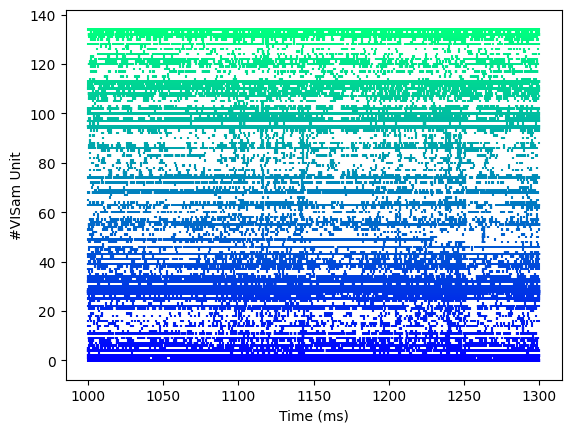

In [87]:
def get_spikes_in_time_interval(session, regionstr, time_start, time_end):
    #Filter neurons in the desired region
    #IDs of these neuron are set as the indices of the units table
    region_ids = session.units[session.units["ecephys_structure_acronym"]==regionstr].index.values

    #Get the spike times as a list of numpy arrays instead of dictionary
    #spike_times[id] is a numpy array
    region_spikes = []
    for id in region_ids:
        #Filter spikes in the interval (time_start, time_end) ms.
        #A single neuron can have 20000 spikes, and eventplot would struggle
        spikes = session.spike_times[id]
        region_spikes.append(spikes[(spikes > time_start) & (spikes < time_end)])

    return region_spikes 

plt.figure()

#Cool colors from the colormap, one per each neuron
visam_spikes = get_spikes_in_time_interval(oursession, "VISam", 1000, 1300)
cmap = matplotlib.colormaps.get_cmap("winter")
unitcolors = [cmap(x) for x in np.linspace(0,1,len(visam_spikes))] 

#Do the eventplot!
plt.eventplot(visam_spikes, orientation="horizontal", color=unitcolors)
plt.xlabel("Time (ms)")
plt.ylabel("#VISam Unit")
plt.show()

del visam_spikes #Free unused memory

However, these spikes do not happen in the void. The mouse is looking at images. Which image was the mouse viewing? Can we see differences?

The information about when a stimulus starts and ends, as well as its features (luminosity, angle...) can be seen in the stimulus table. If the stimulus is animated, the features' values change with time. The name of the stimuli can be found in the `oursession.metadata["stimulus_names"]` variable or in the linked cheatsheet and then loaded `get_stimulus_table(sti_name)`. 

In [88]:
#Load the flahses. Observe how the "color" property changes rapidly
flashes = oursession.get_stimulus_table("flashes")
flashes

c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\Asus\anaconda3\envs\envallen\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,stimulus_block,start_time,stop_time,color,size,orientation,contrast,spatial_frequency,phase,stimulus_name,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,1.0,1285.929787,1286.179996,-1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250209,244
3648,1.0,1287.931477,1288.181681,-1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250204,244
3649,1.0,1289.933157,1290.183361,-1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250204,244
3650,1.0,1291.934847,1292.185046,-1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250199,244
3651,1.0,1293.936507,1294.186708,1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250202,245
...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,1576.172387,1576.422593,1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250207,245
3793,1.0,1578.174047,1578.424256,1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250209,245
3794,1.0,1580.175687,1580.425903,-1.0,"[300.0, 300.0]",0.0,0.8,"[0.0, 0.0]","[0.0, 0.0]",flashes,0.250217,244


In [100]:
# --- Exercise 2: 5 minutes ---
# We have loaded here the static gratings table. 
#Inspect the table's columns and find out the angles used.
#Create two variables, gra0 and gra90, filtering for angle 0 and 90, respectively 

gratings = oursession.get_stimulus_table("static_gratings")

# ?
gra0 = gratings[gratings['orientation'] == 0]
gra90 = gratings[gratings['orientation'] == 90]


# ?


# ?


# ?


# ?


# ?


In [96]:
#Get the ids of our desired region
visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"] == "VISam"].index.values

#Each stimulus has its own id too
#Let's filter the flashes
flashes_ids = flashes.index.values

#Get the spike times of our VISam neurons making t=0 at the 
#moment at which the flashes start!
visam_flash_spk = oursession.presentationwise_spike_times(
    stimulus_presentation_ids=flashes_ids,
    unit_ids=visam_ids
)

#Observe that flashes are presented to the mice several times. How many?
#nunique counts number of unique values in a column in Pandas...
n = visam_flash_spk["stimulus_presentation_id"].nunique()
print(f"Mouse saw flashes {n} times")

Mouse saw flashes 150 times


In the previous code, note that the flashes are presented to mouse once, but each time with different properties. We can, for example, plot the average firing rate of the neurons during the first flash

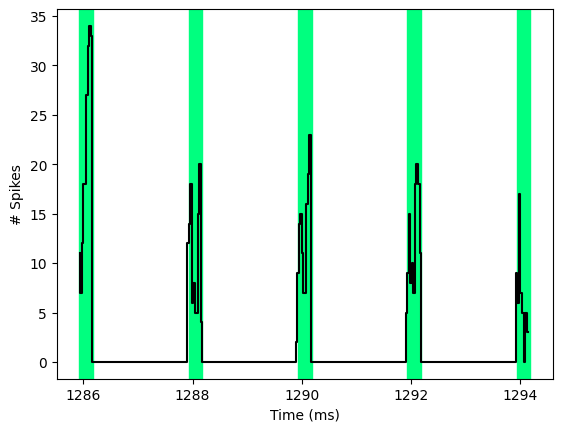

In [97]:
#Get the id of the presentation from the flashes table
nflashes = 5
id0 = flashes.index.values[0]
idf = flashes.index.values[nflashes-1]

#Then obtain all the rows in the spiketime table with presentation index in the interval [id0, idf]
#Spikes are very fast so even in 1ms we can have several!
mask = (visam_flash_spk["stimulus_presentation_id"] >= id0) & (visam_flash_spk["stimulus_presentation_id"] <= idf) 
visam_flash_spk_first = visam_flash_spk[mask] 
del mask #Free memory

#To compute total firing rate, we compute number spikes/ unit time.
#Let's time bin all neurons without looking at who fired
#Notice that the spike times are the indices of this table!
first_spiket = visam_flash_spk_first.index.values[0]
last_spiket = visam_flash_spk_first.index.values[-1]

#Average time between spikes, "natural scale" to bin 
av_iei = np.mean(np.diff(visam_flash_spk_first.index.values))
dt = 2*av_iei
bins = np.arange(first_spiket, last_spiket, dt) 
firingrate, edges = np.histogram(visam_flash_spk_first.index.values, bins=bins)

#Obtain the intervals at which the stimulus happened 
flashstart = flashes["start_time"].values[:nflashes]
flashend = flashes["stop_time"].values[:nflashes]


plt.figure()
#Center the edges of our histogram and show the firing rate 
center_edges = (edges[:-1] + edges[1:])/2
plt.step(center_edges, firingrate, color="black")

#Let's mark where the stimulus happend with a colored area
for t0, tf in zip(flashstart, flashend):
    plt.axvspan(t0, tf, color="springgreen")

plt.xlabel("Time (ms)")
plt.ylabel("# Spikes")
plt.show()

Observe that neuronal activity is not zero between flashes: we have just *filtered* the activity outside of them (we selected spikes which happened when their `stimulus_presentation_id` is betwen two values). The entire firing rate can be obtained filtering just by time, as before 

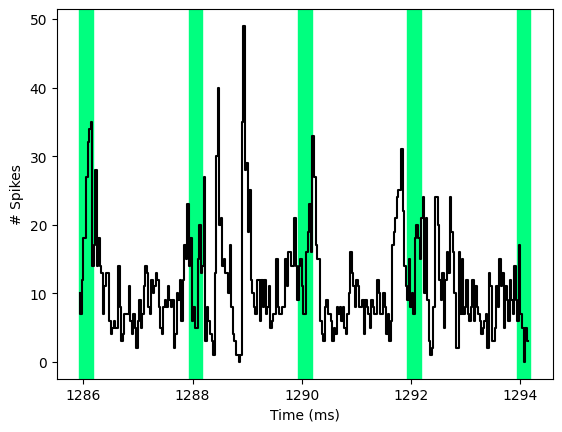

In [99]:
#Similar code as in the raster plot to filter VISam spikes by time, using
#the two variables first_spiket and last_spiket that we found above
#Also we just get all the times in numpy array: we do not care about who spiked
#(last time it was a list of np arrays, now it's a single np array)
visam_spikes = np.array([])
for id in visam_ids:
    spikes = oursession.spike_times[id]
    visam_spikes = np.concatenate((visam_spikes, spikes[(spikes > first_spiket) & (spikes < last_spiket)]))

#Computation of inter-event interval is the same as before
av_iei = np.mean(np.diff(visam_flash_spk_first.index.values))
dt = 2*av_iei
bins = np.arange(first_spiket, last_spiket, dt) 
firingrate, edges = np.histogram(visam_spikes, bins=bins)

del visam_spikes


#Same image!
plt.figure()
center_edges = (edges[:-1] + edges[1:])/2
plt.step(center_edges, firingrate, color="black")

for t0, tf in zip(flashstart, flashend):
    plt.axvspan(t0, tf, color="springgreen")

plt.xlabel("Time (ms)")
plt.ylabel("# Spikes")
plt.show()


In [ ]:
# --- Exercise 3: 10 min ---
# Use the get_spikes_in_time_interval function we defined above to create rasterplots.
# First generate gr0_spikes and gr90_spikes 
# Create two raster plots, showing VISp neuron spikes for a SINGLE presentation of the gratings 
# Is there any difference?


# ????? 
presentation_index = 1 
pres0 = gra0.iloc[presentation_index,:]
pres90 = gra90.iloc[presentation_index,:]

# ?

#Cool colors from the colormap, one per each neuron
visam_spikes = get_spikes_in_time_interval(oursession, "VISam", 1000, 1300)
cmap = matplotlib.colormaps.get_cmap("winter")
unitcolors = [cmap(x) for x in np.linspace(0,1,len(visam_spikes))] 

#Do the eventplot!
plt.eventplot(visam_spikes, orientation="horizontal", color=unitcolors)
plt.xlabel("Time (ms)")
plt.ylabel("#VISam Unit")
plt.show()

# ?


# ?


# ?


# ?


# ?

del gr0_spikes, gr90_spikes #Free unused memory

# Decoding from neuronal activity

Our last task is to build a simple decoder that is able to classify images from some properties of neuronal data. Here we will loosely follow the [Quickstart guide](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quickstart.html) and build a Support Vector Machine to do a classification task. The idea is to use the "natural scenes" stimuli and try to recognize which photo was presented to the mouse as a function of the spiking activity. 

## Stimulus download

First of all, let's explore the [natural scenes](https://observatory.brain-map.org/visualcoding/stimulus/natural_scenes)! These are not downloaded yet. Photos are indexed by numbers, and can be downloaded separately, so they can be retrieved on-the-fly. Let's download them all. They will be downloaded in the `.tiff` format, in the same folder where the `manifest.json` file is, and take 120MB and 10 minutes of download.

**During the session today, we will not download the images, which can be done later**

In [104]:
#Download the 118 photos of the natural scenes. 
#First time they need to be downloaded.
nphotos = 118
for i in range(nphotos):
    tmp = cache.get_natural_scene_template(i)
del tmp

#Convert them to use with the MiniSDK if needed
#converter.write_natural_images()

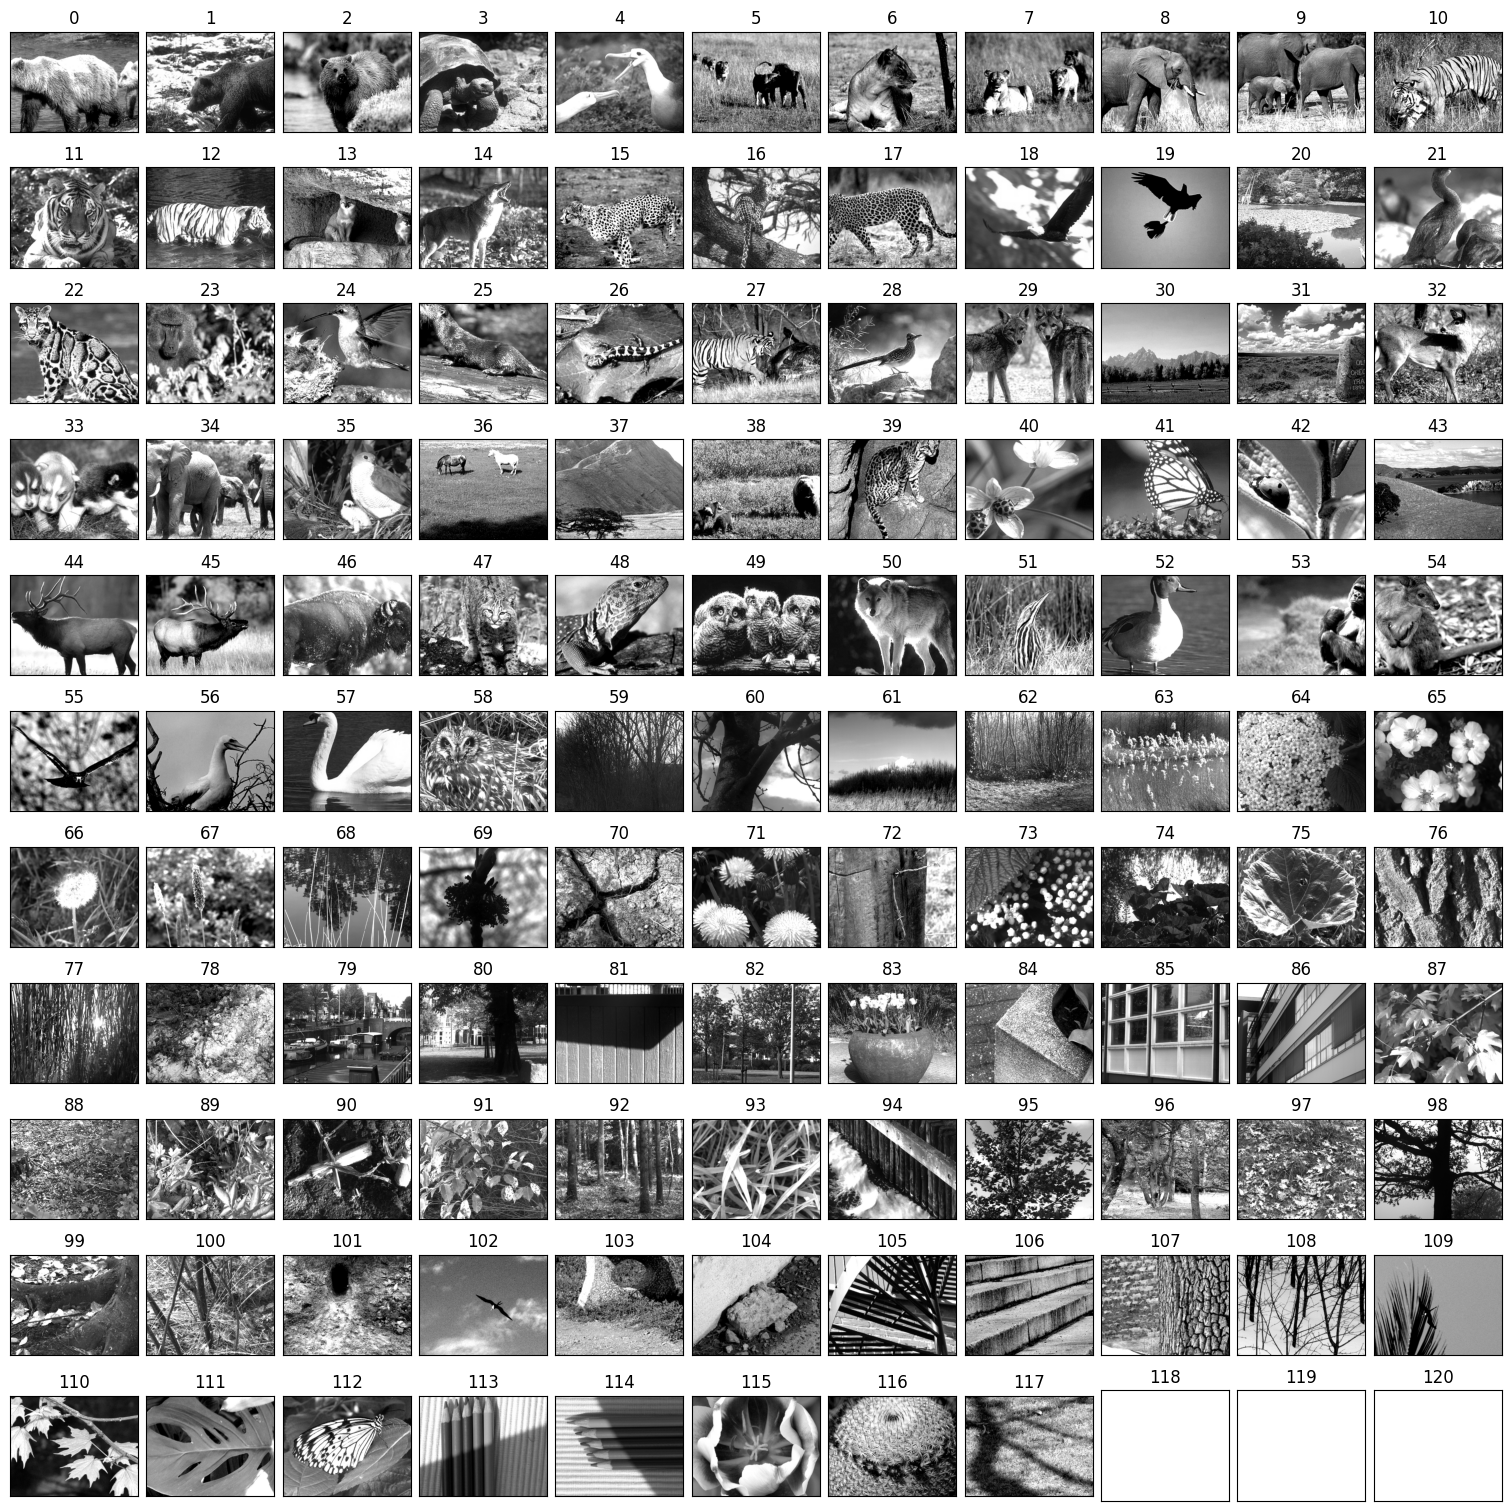

In [105]:
#Let's create a beautiful 11x11 reference plot with all the images
fig, axes = plt.subplots(ncols=11, nrows=11, figsize=(15,15), layout="constrained")
L = 11
for x in range(L):
    for y in range(L):
        index = y + x*L 
        axes[x,y].set_title(index)
        axes[x,y].set_xticks([])
        axes[x,y].set_yticks([])
        if index < 118:
            axes[x,y].imshow(cache.get_natural_scene_template(index), cmap="gray")

plt.savefig("natural_scenes.pdf", dpi=300, bbox_inches="tight")
plt.show()

Observe that movies can be downloaded in the exact same way, using the `cache.get_natural_movie_template(id)` function. Notice that there is only three movies, but in brain observatory only 1 and 3 were watched so `ìd=1,3`. They weight around a 700 MB together. 

## Decoding

Let's, however, focus on the images. We expect each neuron to respond to different kind of stimuli (different angles, luminosity...) in different places of the screen. Hence, the firing rate of the measured neurons should correlate with each image.  An extremely naive decoding scheme is to just use the number of spikes that each neuron had during each presentation.

We can construct a table using presentation id as rows and neurons and columns, so each cell contains the neuron's number of spikes while the image was shown on the screen, and feed this to a classifier. 


In [106]:
#Get the ids of the images and the units 
image_id = oursession.get_stimulus_table("natural_scenes").index.values
visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"]=="VISam"].index.values

#Tables of the spikes happened during these presentations
visam_spikes = oursession.presentationwise_spike_times(
    stimulus_presentation_ids=image_id,
    unit_ids = visam_ids
)

#Let's construct the table we want in a naive version.
#Start by creating a 0-filled Pandas dataframe with the desired index and colums 
spikes_presentation = pd.DataFrame(
    0,
    index = image_id,
    columns = visam_ids, 
    dtype=int
    )

#Iterate manually over every row and just add the counting
for index, row in visam_spikes.iterrows():
    image = int(row["stimulus_presentation_id"])
    unit = int(row["unit_id"])
    spikes_presentation.loc[image, unit] += 1

spikes_presentation

,951092050,951092075,951092303,951092398,951092369,951092410,951092450,951092437,951092475,951092488,...,951098487,951098546,951098530,951098560,951098658,951098850,951098807,951098773,951098871,951098928
51355,6,2,3,2,2,0,3,19,0,2,...,0,0,1,6,0,1,9,9,0,11
51356,10,3,4,3,4,0,1,20,0,0,...,0,0,0,1,0,0,12,11,2,8
51357,8,0,4,4,4,0,3,17,0,0,...,0,0,2,4,0,1,9,6,0,8
51358,9,5,2,8,5,1,9,10,0,4,...,0,0,4,3,2,1,18,9,2,10
51359,7,1,2,6,7,0,6,10,0,5,...,0,0,5,3,5,0,10,6,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,1,5,3,0,5,2,0,0,0,6,...,0,1,0,0,0,0,1,0,0,3
68225,1,6,1,0,7,2,2,6,0,4,...,2,0,0,2,0,1,5,9,0,7
68226,0,7,4,0,6,1,0,9,0,1,...,0,0,0,7,0,0,2,2,1,6
68227,5,1,5,0,7,3,1,3,0,0,...,0,0,0,5,0,1,4,1,0,9


The code above is slow. Using dedicated Panda's functions it can get way faster! If you have little experience with Pandas, check tutorials on how to use `groupby` function, which is useful to manipulate data.

In [107]:
#Get the ids of the images and the units 
image_id = oursession.get_stimulus_table("natural_scenes").index.values
visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"]=="VISam"].index.values

#Get the spikes during the session
visam_spikes = oursession.presentationwise_spike_times(
    stimulus_presentation_ids=image_id,
    unit_ids = visam_ids
)

#Add a new column to our table and fill it by counting number of rows with a stimulus presentation and unitid
visam_spikes["count"] = np.zeros(len(visam_spikes))
visam_spikes = visam_spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

#Employ "pivot table" to use the information from visam_spikes to generate a new table where 
#we indicate index, columns, and fill it with the count.
spikes_presentation = pd.pivot_table(
    visam_spikes,
    values="count",
    index="stimulus_presentation_id",
    columns="unit_id",
    fill_value=0.0,
    aggfunc=np.sum
)

#This is 50 times faster!
spikes_presentation

unit_id,951092050,951092075,951092303,951092369,951092398,951092410,951092437,951092450,951092475,951092488,...,951098773,951098807,951098850,951098871,951098928,951099272,951099306,951099320,951099475,951099491
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,
51355,6,2,3,2,2,0,19,3,0,2,...,9,9,1,0,11,0,0,4,0,1
51356,10,3,4,4,3,0,20,1,0,0,...,11,12,0,2,8,0,0,2,0,5
51357,8,0,4,4,4,0,17,3,0,0,...,6,9,1,0,8,0,0,0,0,3
51358,9,5,2,5,8,1,10,9,0,4,...,9,18,1,2,10,0,0,0,0,3
51359,7,1,2,7,6,0,10,6,0,5,...,6,10,0,1,10,0,0,4,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,1,5,3,5,0,2,0,0,0,6,...,0,1,0,0,3,2,2,0,0,1
68225,1,6,1,7,0,2,6,2,0,4,...,9,5,1,0,7,0,0,1,0,4
68226,0,7,4,6,0,1,9,0,0,1,...,2,2,0,1,6,0,0,1,0,1


Now we import Scikit-Learn module and use its built-int Support Vector Machine. Scikit does separate the data into training and test and it evaluates it. We just need to set up what is the target to learn, which is the `frame` property of the presentation (tells us the index of the image used). 

In [108]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [109]:
#Find the frame that corresponds to the presentation id and convert it to int numpy array.
targets = oursession.get_stimulus_table("natural_scenes").loc[image_id, "frame"]
targets = targets.values.astype(int)
labels = np.unique(targets)  #There should be 118 labels, one per image.

#The codification of the images, as a 2D numpy array instead 
spikes_presentation = spikes_presentation.values.astype(float)

With this, we use the code for the SVC (obtained directly from the tutorial, comments are mine!)

In [110]:
#Initialize the vectors
accuracies = []
confusions = []

#KFold.split automatically splits our big table into n_splits parts. Training then is done with n_splits-1 
#parts and the remaining one is used for test. The procedure then is cross-validated.
for train_indices, test_indices in KFold(n_splits=5).split(spikes_presentation):
    
    #Generate the Support Vector Machine and fit it using the training dataset
    clf = svm.SVC(gamma="scale", kernel="rbf")
    clf.fit(spikes_presentation[train_indices], targets[train_indices])
    
    #Get the test set and try to predict over it
    test_targets = targets[test_indices]
    test_predictions = clf.predict(spikes_presentation[test_indices])
    
    #Compute the accuracy on this test set and save all of them
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=labels))

#Get the mean!
print(f"Cross-validated mean accuracy: {100*np.mean(accuracy):.1f}%")
print(f"Chance of random guess: {100/labels.size:.2f}%") #1/118 

Cross-validated mean accuracy: 17.6%
Chance of random guess: 0.84%


Once we have our decoder, we can check for example, the images that can be decoded best. In the tutorial this is done only for best and worst, let's check a top 5!

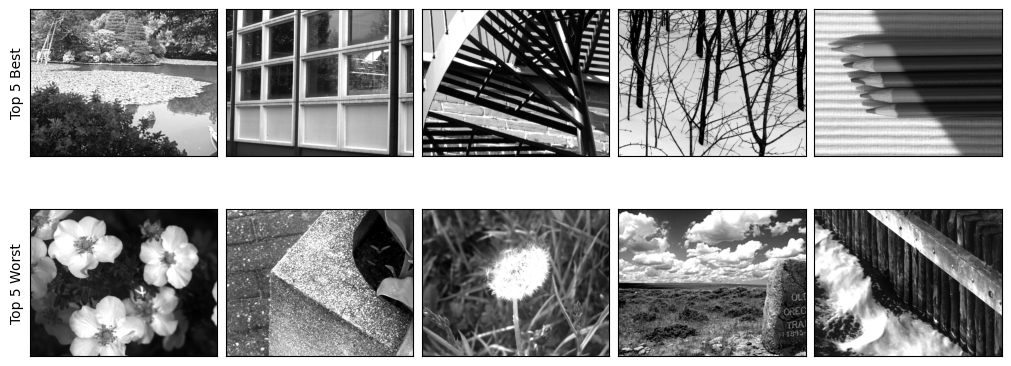

In [111]:
#Get the mean confusion for each one of the images, which will be used to sort best and worse
mean_confusion = np.mean(confusions, axis=0)
scoresindex = np.argsort(np.diag(mean_confusion)) #Sort scores to see top and worst

#Indices of best/worst 
top = 5
best = scoresindex[-1:-top-1:-1] 
worst = scoresindex[:top]

#Start the figure
fig, axes = plt.subplots(nrows=2, ncols=top, figsize=(10,4), layout="constrained")

for i in range(top):
    #Plot the obtained images
    axes[0,i].imshow(cache.get_natural_scene_template(best[i]), cmap="gray")
    axes[1,i].imshow(cache.get_natural_scene_template(worst[i]), cmap="gray")

    #Eliminate all ticks
    for ax in axes[:,i]:
        ax.set_xticks([])
        ax.set_yticks([])

#Labels
axes[0,0].set_ylabel(f"Top {top} Best")
axes[1,0].set_ylabel(f"Top {top} Worst")

plt.show()

# What can YOU do?

Here we propose some ideas that might interesting to study, from what we have seen in the dataset...

- Quantify a response property of neurons in an area
- Receptive field size, response delay, ability to decode different orientations of gratings (static or dynamic), ability to decode different images, dimensionality of the representation, …
- Probe how a response property changes across brain areas 
- Characterize differences in a response property between excitatory and inhibitory neurons (Waveform width can be used to identify them)
- Build a low dimensional representation of visual responses with your favorite dimensionality reduction technique (e.g. PCA) and use it to characterize how neural responses change across areas,  stimuli (gratings, natural movies, ...), animal state (running or stationary)
- Investigate how the ability to decode stimuli (e.g. orientation of gratings or identity of natural images) changes 
    - if the number of neurons used is changed (could also combine recordings across sessions if needed)
    - if other observables are available to the decoder (interspike interval, running state of the animal, ...)
    - if different time bins are used. 
    - if a fixed time bin but with different delays from stimulus onset are used. 






- **Any other interesting idea you would like to look at! If you have any, please discuss with us!**